<a href="https://colab.research.google.com/github/edsonportosilva/OptiCommPy/blob/main/examples/basic_IMDD_PAM_transmission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulate a basic IM-DD PAM transmission system

In [1]:
if 'google.colab' in str(get_ipython()):    
    ! git clone -b main https://github.com/edsonportosilva/OptiCommPy
    from os import chdir as cd
    cd('/content/OptiCommPy/')
    ! pip install . 

In [2]:
import numpy as np
from commpy.utilities  import upsample
from optic.models.devices import mzm, photodiode, edfa
from optic.models.channels import linFiberCh
from optic.comm.modulation import GrayMapping, modulateGray, demodulateGray
from optic.comm.metrics import  theoryBER
from optic.dsp.core import firFilter, pulseShape, lowPassFIR, pnorm, signal_power
from optic.core import parameters
from optic.plot import eyediagram, pconst
import matplotlib.pyplot as plt
from scipy.special import erfc
from tqdm.notebook import tqdm
import scipy as sp

In [3]:
from IPython.core.display import HTML
from IPython.core.pylabtools import figsize

HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [4]:
figsize(10, 3)

In [5]:
# %load_ext autoreload
# %autoreload 2

### Intensity modulation (IM) with Pulse Amplitude Modulation (PAM)

Average power of the modulated optical signal [mW]: 0.500 mW
Average power of the modulated optical signal [dBm]: -3.008 dBm


C:\Users\edson\AppData\Roaming\Python\Python39\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


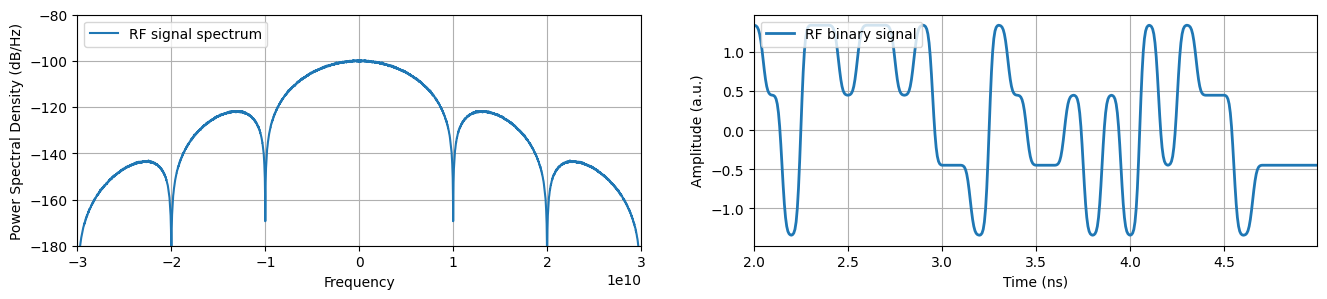

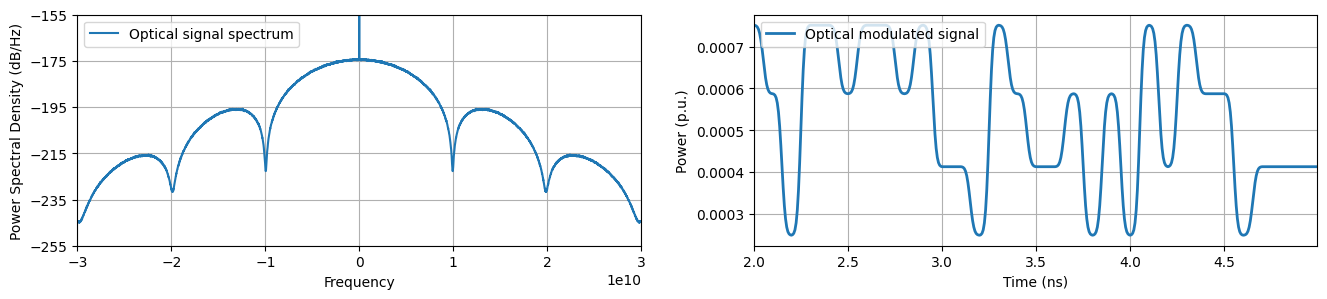

In [6]:
# simulation parameters
SpS = 16           # samples per symbol
M = 4              # order of the modulation format
Rs = 10e9          # Symbol rate (for OOK case Rs = Rb)
Tsymb = 1/Rs       # Symbol period in seconds
Fs = 1/(Tsymb/SpS) # Signal sampling frequency (samples/second)
Ts = 1/Fs          # Sampling period

# MZM parameters
Vπ = 2
Vb = -Vπ/2
Pi_dBm = 0 # laser optical power at the input of the MZM in dBm
Pi = 10**(Pi_dBm/10)*1e-3 # convert from dBm to W

# generate pseudo-random bit sequence
bitsTx = np.random.randint(2, size=int(np.log2(M)*1e6))

# generate ook modulated symbol sequence
symbTx = modulateGray(bitsTx, M, 'pam')    
symbTx = pnorm(symbTx) # power normalization

# upsampling
symbolsUp = upsample(symbTx, SpS)

# typical NRZ pulse
pulse = pulseShape('nrz', SpS)
pulse = pulse/max(abs(pulse))

# pulse shaping
sigTx = firFilter(pulse, symbolsUp)

# optical modulation
Ai = np.sqrt(Pi)*np.ones(sigTx.size)
sigTxo = mzm(Ai, 0.25*sigTx, Vπ, Vb)

print('Average power of the modulated optical signal [mW]: %.3f mW'%(signal_power(sigTxo)/1e-3))
print('Average power of the modulated optical signal [dBm]: %.3f dBm'%(10*np.log10(signal_power(sigTxo)/1e-3)))

fig, axs = plt.subplots(1, 2, figsize=(16,3))
interval = np.arange(16*20,16*50)
t = interval*Ts/1e-9

# plot psd
axs[0].set_xlim(-3*Rs,3*Rs);
axs[0].set_ylim(-180,-80);
axs[0].psd(sigTx,Fs=Fs, NFFT = 16*1024, sides='twosided', label = 'RF signal spectrum')
axs[0].legend(loc='upper left');

axs[1].plot(t, sigTx[interval], label = 'RF binary signal', linewidth=2)
axs[1].set_ylabel('Amplitude (a.u.)')
axs[1].set_xlabel('Time (ns)')
axs[1].set_xlim(min(t),max(t))
axs[1].legend(loc='upper left')
axs[1].grid()

fig, axs = plt.subplots(1, 2, figsize=(16,3))
# plot psd
axs[0].set_xlim(-3*Rs,3*Rs);
axs[0].set_ylim(-255,-155);
axs[0].psd(np.abs(sigTxo)**2, Fs=Fs, NFFT = 16*1024, sides='twosided', label = 'Optical signal spectrum')
axs[0].legend(loc='upper left');

axs[1].plot(t, np.abs(sigTxo[interval])**2, label = 'Optical modulated signal', linewidth=2)
axs[1].set_ylabel('Power (p.u.)')
axs[1].set_xlabel('Time (ns)')
axs[1].set_xlim(min(t),max(t))
axs[1].legend(loc='upper left')
axs[1].grid()

### Linear fiber channel model (fiber + EDFA opt. amplifier)

In [7]:
# linear optical channel
L = 40         # total link distance [km]
α = 0.2        # fiber loss parameter [dB/km]
D = 16         # fiber dispersion parameter [ps/nm/km]
Fc = 193.1e12  # central optical frequency [Hz]

sigCh = linFiberCh(sigTxo, L, α, D, Fc, Fs)

# receiver pre-amplifier
G = α*L    # edfa gain
NF = 4.5   # edfa noise figure
sigCh = edfa(sigCh, Fs, G, NF, Fc)

### Direct-detection (DD) pin receiver model

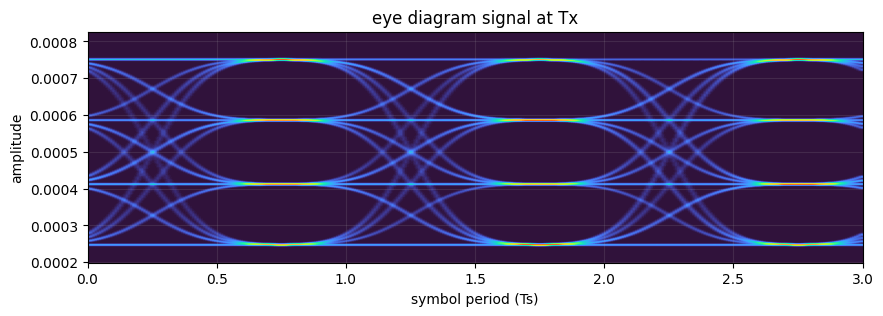

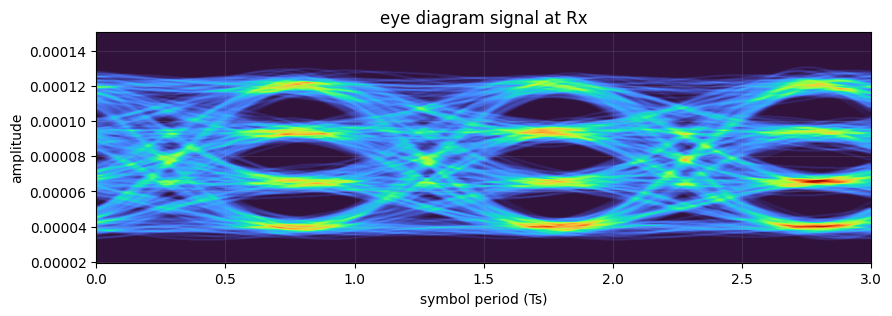

In [8]:
# ideal photodiode (noiseless, no bandwidth limitation)
paramPD = parameters()
paramPD.ideal = True
I_Rx_ideal = photodiode(sigTxo.real, paramPD)

# noisy photodiode (thermal noise + shot noise + bandwidth limitation)
paramPD = parameters()
paramPD.ideal = False
paramPD.B = Rs
paramPD.Fs = Fs

I_Rx = photodiode(sigCh, paramPD)

discard = 100

eyediagram(I_Rx_ideal[discard:-discard], I_Rx.size-2*discard, SpS, plotlabel='signal at Tx', ptype='fancy')
eyediagram(I_Rx[discard:-discard], I_Rx.size-2*discard, SpS, plotlabel='signal at Rx', ptype='fancy')

Number of counted errors = 4 
BER = 2.00e-06 


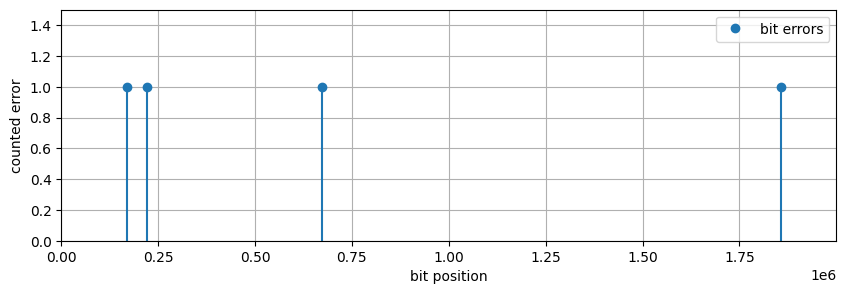

In [9]:
I_Rx = I_Rx/np.std(I_Rx)

# capture samples in the middle of signaling intervals
symbRx = I_Rx[0::SpS]

# subtract DC level and normalize power
symbRx = symbRx - symbRx.mean()
symbRx = pnorm(symbRx)

# demodulate symbols to bits with minimum Euclidean distance 
const = GrayMapping(M,'pam') # get PAM constellation
Es = signal_power(const) # calculate the average energy per symbol of the PAM constellation

bitsRx = demodulateGray(np.sqrt(Es)*symbRx, M, 'pam')

discard = 100
err = np.logical_xor(bitsRx[discard:bitsRx.size-discard], bitsTx[discard:bitsTx.size-discard])
BER = np.mean(err)

#Pb = 0.5*erfc(Q/np.sqrt(2)) # theoretical error probability
print('Number of counted errors = %d '%(err.sum()))
print('BER = %.2e '%(BER))
#print('Pb = %.2e '%(Pb))

err = err*1.0
err[err==0] = np.nan

plt.plot(err,'o', label = 'bit errors')
plt.vlines(np.where(err>0), 0, 1)
plt.xlabel('bit position')
plt.ylabel('counted error')
plt.legend()
plt.grid()
plt.ylim(0, 1.5)
plt.xlim(0,err.size);

### Generate curve of BER vs received input power

In [10]:
# simulation parameters
SpS = 16            # Samples per symbol
M = 4               # order of the modulation format
Rs = 40e9           # Symbol rate (for the OOK case, Rs = Rb)
Tsymb = 1/Rs        # Symbol period in seconds
Fs = 1/(Tsymb/SpS)  # Signal sampling frequency (samples/second)
Ts = 1/Fs           # Sampling period

# MZM parameters
Vπ = 2
Vb = -Vπ/2

# typical NRZ pulse
pulse = pulseShape('nrz', SpS)
pulse = pulse/max(abs(pulse))

powerValues = np.arange(-20,-4) # power values at the input of the pin receiver
BER = np.zeros(powerValues.shape)
Pb = np.zeros(powerValues.shape)

const = GrayMapping(M,'pam') # get PAM constellation
Es = signal_power(const) # calculate the average energy per symbol of the PAM constellation
    
discard = 100
for indPi, Pi_dBm in enumerate(tqdm(powerValues)):
    
    Pi = 10**((Pi_dBm+3)/10)*1e-3 # optical signal power in W at the MZM input

    # generate pseudo-random bit sequence
    bitsTx = np.random.randint(2, size=int(np.log2(M)*1e6))
    n = np.arange(0, bitsTx.size)

    # generate ook modulated symbol sequence
    symbTx = modulateGray(bitsTx, M, 'pam')    
    symbTx = pnorm(symbTx) # power normalization

    # upsampling
    symbolsUp = upsample(symbTx, SpS)

    # pulse formatting
    sigTx = firFilter(pulse, symbolsUp)

    # optical modulation
    Ai = np.sqrt(Pi)*np.ones(sigTx.size)
    sigTxo = mzm(Ai, 0.25*sigTx, Vπ, Vb)

    # pin receiver
    paramPD = parameters()
    paramPD.ideal = False
    paramPD.B = Rs
    paramPD.Fs = Fs

    I_Rx = photodiode(sigTxo.real, paramPD)
    I_Rx = I_Rx/np.std(I_Rx)

    # capture samples in the middle of signaling intervals
    symbRx = I_Rx[0::SpS]

    # subtract DC level and normalize power
    symbRx = symbRx - symbRx.mean()
    symbRx = pnorm(symbRx)
    
    snr = signal_power(symbRx)/(2*signal_power(symbRx-symbTx))
    EbN0 = 10*np.log10(snr/np.log2(M))
    
    # demodulate symbols to bits with minimum Euclidean distance 
    bitsRx = demodulateGray(np.sqrt(Es)*symbRx, M, 'pam')

    err = np.logical_xor(bitsRx[discard:bitsRx.size-discard], bitsTx[discard:bitsTx.size-discard])
    BER[indPi] = np.mean(err)
    Pb[indPi] = theoryBER(M, EbN0, 'pam') # probability of bit error (theory)

  0%|          | 0/16 [00:00<?, ?it/s]

C:\Users\edson\AppData\Local\Temp\ipykernel_8164\1406766809.py:2: RuntimeWarning: divide by zero encountered in log10
  plt.plot(powerValues, np.log10(Pb),'--',label='Pb (theory)')
C:\Users\edson\AppData\Local\Temp\ipykernel_8164\1406766809.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.plot(powerValues, np.log10(BER),'o',label='BER')


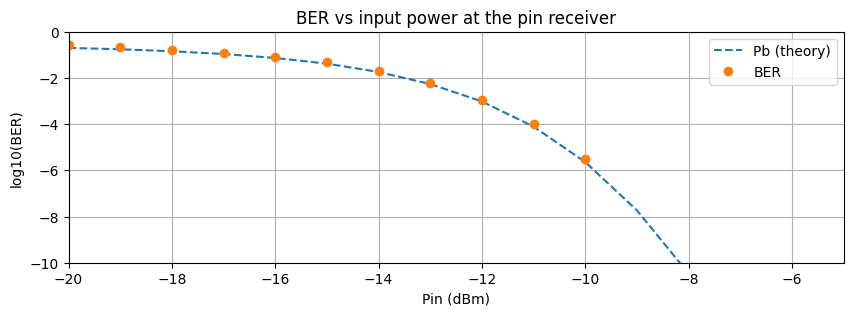

In [11]:
plt.figure()
plt.plot(powerValues, np.log10(Pb),'--',label='Pb (theory)')
plt.plot(powerValues, np.log10(BER),'o',label='BER')
plt.grid()
plt.ylabel('log10(BER)')
plt.xlabel('Pin (dBm)');
plt.title('BER vs input power at the pin receiver')
plt.legend();
plt.ylim(-10,0);
plt.xlim(min(powerValues), max(powerValues));

### Generate curve of BER vs transmission distance

In [12]:
# simulation parameters
SpS = 16            # Samples per symbol
M = 4               # order of the modulation format
Rs = 10e9           # Symbol rate (for the OOK case, Rs = Rb)
Tsymb = 1/Rs        # Symbol period in seconds
Fs = 1/(Tsymb/SpS)  # Signal sampling frequency (samples/second)
Ts = 1/Fs           # Sampling period

# MZM parameters
Pi_dBm = 0 # optical signal power in dBm at the MZM input
Vπ = 2
Vb = -Vπ/2
Pi = 10**((Pi_dBm)/10)*1e-3 # optical signal power in W at the MZM input

# typical NRZ pulse
pulse = pulseShape('nrz', SpS)
pulse = pulse/max(abs(pulse))

# fiber channel parameters
distance = np.arange(0,101,5) # transmission distance in km
α = 0.2        # fiber loss parameter [dB/km]
D = 16         # fiber dispersion parameter [ps/nm/km]
Fc = 193.1e12  # central optical frequency [Hz]
    
BER = np.zeros(distance.shape)
Pb = np.zeros(distance.shape)

const = GrayMapping(M,'pam') # get PAM constellation
Es = signal_power(const) # calculate the average energy per symbol of the PAM constellation
    
discard = 100
for indL, L in enumerate(tqdm(distance)):
        
    # generate pseudo-random bit sequence
    bitsTx = np.random.randint(2, size=int(np.log2(M)*1e5))
    n = np.arange(0, bitsTx.size)

    # generate ook modulated symbol sequence
    symbTx = modulateGray(bitsTx, M, 'pam')    
    symbTx = pnorm(symbTx) # power normalization

    # upsampling
    symbolsUp = upsample(symbTx, SpS)

    # pulse formatting
    sigTx = firFilter(pulse, symbolsUp)

    # optical modulation
    Ai = np.sqrt(Pi)*np.ones(sigTx.size)
    sigTxo = mzm(Ai, 0.25*sigTx, Vπ, Vb)
    
    # linear optical channel   
    sigCh = linFiberCh(sigTxo, L, α, D, Fc, Fs)

    # receiver pre-amplifier
    if L > 0:
        G = α*L    # edfa gain
        NF = 4.5   # edfa noise figure
        sigCh = edfa(sigCh, Fs, G, NF, Fc)

    # pin receiver
    paramPD = parameters()
    paramPD.ideal = False
    paramPD.B = Rs
    paramPD.Fs = Fs

    I_Rx = photodiode(sigCh, paramPD)
    I_Rx = I_Rx/np.std(I_Rx)

    # capture samples in the middle of signaling intervals
    symbRx = I_Rx[0::SpS]

    # subtract DC level and normalize power
    symbRx = symbRx - symbRx.mean()
    symbRx = pnorm(symbRx)
    
    snr = signal_power(symbRx)/(2*signal_power(symbRx-symbTx))
    EbN0 = 10*np.log10(snr/np.log2(M))
    
    # demodulate symbols to bits with minimum Euclidean distance 
    bitsRx = demodulateGray(np.sqrt(Es)*symbRx, M, 'pam')

    err = np.logical_xor(bitsRx[discard:bitsRx.size-discard], bitsTx[discard:bitsTx.size-discard])
    BER[indL] = np.mean(err)
    Pb[indL] = theoryBER(M, EbN0, 'pam') # probability of bit error (theory)

  0%|          | 0/21 [00:00<?, ?it/s]

C:\Users\edson\AppData\Local\Temp\ipykernel_8164\2614596433.py:2: RuntimeWarning: divide by zero encountered in log10
  plt.plot(distance, np.log10(Pb),'--',label='Pb (theory)')
C:\Users\edson\AppData\Local\Temp\ipykernel_8164\2614596433.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.plot(distance, np.log10(BER),'o',label='BER')


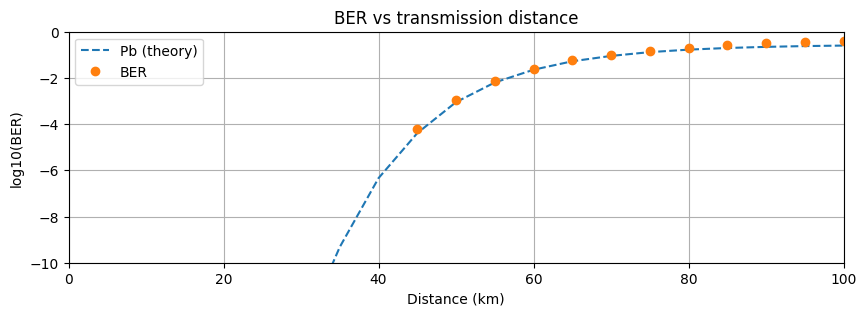

In [13]:
plt.figure()
plt.plot(distance, np.log10(Pb),'--',label='Pb (theory)')
plt.plot(distance, np.log10(BER),'o',label='BER')
plt.grid()
plt.ylabel('log10(BER)')
plt.xlabel('Distance (km)');
plt.title('BER vs transmission distance')
plt.legend();
plt.ylim(-10,0);
plt.xlim(min(distance), max(distance));